In [1]:
import pandas as pd

# Load the data into a pandas DataFrame
data = pd.read_csv('merged_lz_houston_data.csv', parse_dates=['DateTime'])

# Ensure 'Settlement Point Price' and 'QUANTITY' are treated as numeric columns.
# Coerce any errors during conversion to NaN, which will be handled during the filling process.
# Replace 'Settlement Point Price' with the actual column name from your CSV if it's different.
data['Settlement_Point_Price'] = pd.to_numeric(data['Settlement Point Price'], errors='coerce')
data['QUANTITY'] = pd.to_numeric(data['QUANTITY'], errors='coerce')

# Set 'DateTime' as the index
data.set_index('DateTime', inplace=True)

# Sort the DataFrame by DateTime to ensure it is in chronological order 
data.sort_index(inplace=True)

# Resample the data to hourly frequency, aggregating with the mean
# Only numeric columns should be included in this operation.

# Should not Average the Data here, they are separate datasets
account_b_data = data[data["ACCOUNT_NUMBER"] == "account_b"][['Settlement_Point_Price', 'QUANTITY']]
account_a_data = data[data["ACCOUNT_NUMBER"] == "account_a"][['Settlement_Point_Price', 'QUANTITY']]

account_b_data = account_b_data.dropna()
account_a_data = account_a_data.dropna()


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Scale your data using MinMaxScaler to help the LSTM converge faster
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(account_a_data[['QUANTITY']].values)

# Convert the dataset into sequences of a specific window size
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# Define the sequence length (number of time steps to look back) and create sequences
seq_length = 4
x, y = sliding_windows(data_scaled, seq_length)

# Convert to PyTorch tensors
dataX = torch.Tensor(x)
dataY = torch.Tensor(y)

# Define the number of splits for cross-validation
n_splits = 4  # For example, you can choose 4-fold cross-validation

# TimeSeriesSplit provides train/test indices to split time series data samples
tscv = TimeSeriesSplit(n_splits=n_splits)

# Iterate over each split
for fold, (train_index, test_index) in enumerate(tscv.split(dataX)):
    # Create training and testing sets for this fold
    trainX, trainY = dataX[train_index], dataY[train_index]
    testX, testY = dataX[test_index], dataY[test_index]
    
    # Create DataLoader instances for training and testing sets
    batch_size = 64  # You can adjust the batch size
    train_dataset = TensorDataset(trainX, trainY)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = TensorDataset(testX, testY)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
import torch.nn as nn

# Define the LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        return out

The LSTM class is defined with parameters for input size, hidden size, output size, and the number of layers.
The forward method initializes the hidden state h0 and cell state c0 with zeros for each batch, ensuring they are on the same device as the input tensor x.
The LSTM output out is passed through a fully connected layer to produce the final output.
The hidden and cell states are detached from the graph after each batch to prevent backpropagation through the entire sequence of states (which is not needed and would significantly increase memory usage).

In [46]:
import torch

# Model initialization and training configuration
num_epochs = 1000
learning_rate = 0.001

input_size = 1  # This should match the last dimension of your input data
hidden_size = 2
num_layers = 1

output_size = 1  # Since you are predicting a single value
 
          
# Instantiate the model
lstm = LSTM(input_size, hidden_size, output_size, num_layers)
lstm = lstm.cuda()  # Ensure model is on CUDA

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    lstm.train()  # Set model to training mode
    total_loss = 0

    for seq, labels in train_loader:
        # Move data to CUDA
        seq, labels = seq.cuda(), labels.cuda()
        #print(f"Input shape: {seq.shape}")  # Add this line to check input shape
        #outputs = lstm(seq)
        # Forward pass
        outputs = lstm(seq)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 100 == 0:  # Print average loss every 100 epochs
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# After training, you might want to save your model
# torch.save(lstm.state_dict(), 'lstm_model.pth')

# Evaluation
lstm.eval()  # Set model to evaluation mode
test_losses = []
with torch.no_grad():
    for seq, labels in test_loader:
        seq, labels = seq.cuda(), labels.cuda()
        outputs = lstm(seq)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss:.4f}')

Epoch [0/1000], Loss: 0.4741
Epoch [100/1000], Loss: 0.0188
Epoch [200/1000], Loss: 0.0185
Epoch [300/1000], Loss: 0.0184
Epoch [400/1000], Loss: 0.0183
Epoch [500/1000], Loss: 0.0183
Epoch [600/1000], Loss: 0.0182
Epoch [700/1000], Loss: 0.0181
Epoch [800/1000], Loss: 0.0181
Epoch [900/1000], Loss: 0.0181
Average Test Loss: 0.0228


In [47]:
# Save the model's state dictionary
torch.save(lstm.state_dict(), 'lstm_model_state_dict.pth')

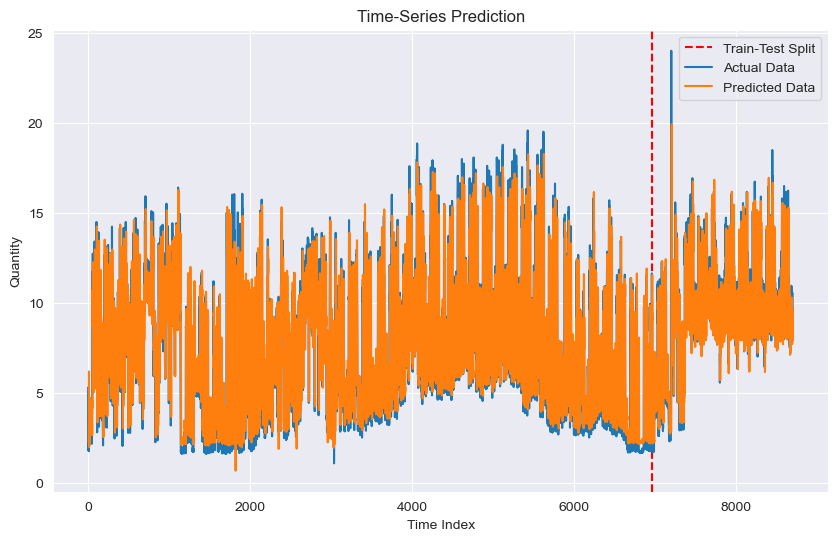

In [48]:
from matplotlib import pyplot as plt
#load the model
lstm = LSTM(input_size, hidden_size, output_size, num_layers).cuda()
lstm.load_state_dict(torch.load('lstm_model_state_dict.pth'))
# Assuming lstm, trainX, testX are defined and loaded with the correct data
lstm.eval()  # Set the model to evaluation mode

# Generate predictions for both training and test sets
train_predict = lstm(trainX.cuda())
test_predict = lstm(testX.cuda())

# Concatenate train and test predictions for full data visualization
full_predict = torch.cat((train_predict, test_predict), 0)

# Inverse transform the predictions and actual data
data_predict = scaler.inverse_transform(full_predict.data.cpu().numpy())
dataY_plot = scaler.inverse_transform(dataY.data.cpu().numpy())

# Calculate the splitting point in the plot for visualizing train-test separation
split_pt = trainX.size(0) + seq_length  # Account for the sequence length

# Plotting
plt.figure(figsize=(10,6))
plt.axvline(x=split_pt, c='r', linestyle='--', label='Train-Test Split')

# Actual data
plt.plot(dataY_plot, label='Actual Data')

# Predictions (overlay on the actual data)
plt.plot(np.arange(seq_length, len(data_predict)+seq_length), data_predict, label='Predicted Data')

plt.title('Time-Series Prediction')
plt.xlabel('Time Index')
plt.ylabel('Quantity')
plt.legend()
plt.show()

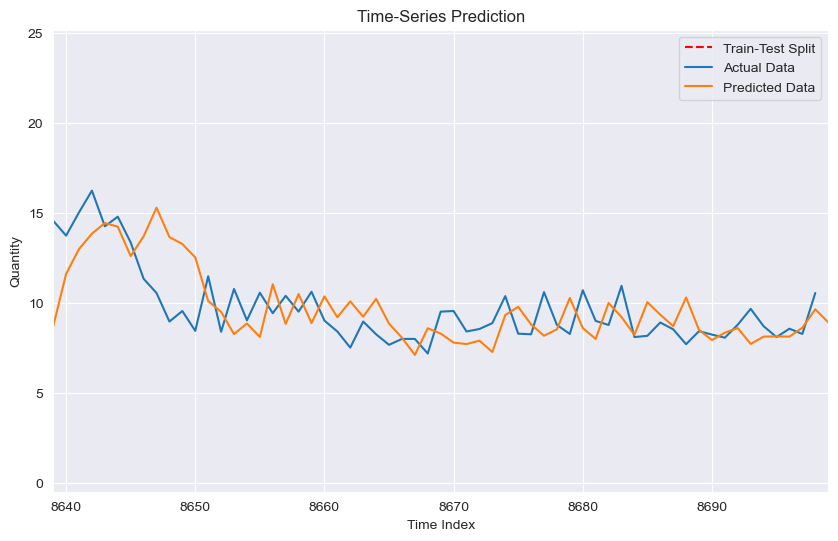

In [49]:
import matplotlib.pyplot as plt
import numpy as np

#Assuming data_predict and dataY_plot are the predicted and actual data, respectively
# Calculate the splitting point in the plot for visualizing train-test separation

plt.figure(figsize=(10,6))
plt.axvline(x=split_pt, c='r', linestyle='--', label='Train-Test Split')


plt.plot(dataY_plot, label='Actual Data')

# Predictions (overlay on the actual data)
plt.plot(np.arange(seq_length, len(data_predict)+seq_length), data_predict, label='Predicted Data')

# Set the title and labels
plt.title('Time-Series Prediction')
plt.xlabel('Time Index')
plt.ylabel('Quantity')

# Set the legend
plt.legend()

last_three_months_start = len(dataY_plot) - 60  # 60 days in the last three months

# Zoom in on the last three months
plt.xlim(last_three_months_start, len(dataY_plot))

plt.show()

In [50]:
# Calculate the mean squared error
mse = np.mean(np.square(dataY_plot - data_predict))
print("Mean Squared Error: %1.5f" % mse)
# Calculate the root mean squared error
rmse = np.sqrt(mse)
print("Root Mean Squared Error: %1.5f" % rmse)

Mean Squared Error: 2.49966
Root Mean Squared Error: 1.58103


# Predict Price without Weather data

In [52]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the data
data = pd.read_csv('merged_lz_houston_data.csv', parse_dates=['DateTime'])

# Convert 'Settlement Point Price' and 'QUANTITY' to numeric and handle errors
data['Settlement_Point_Price'] = pd.to_numeric(data['Settlement Point Price'], errors='coerce')
data['QUANTITY'] = pd.to_numeric(data['QUANTITY'], errors='coerce')

# Set 'DateTime' as the index and sort the DataFrame
data.set_index('DateTime', inplace=True)
data.sort_index(inplace=True)

# Filter out the data for account A and B, and drop NA values
account_a_data = data[data["ACCOUNT_NUMBER"] == "account_a"][['Settlement_Point_Price']].dropna()
account_b_data = data[data["ACCOUNT_NUMBER"] == "account_b"][['Settlement_Point_Price']].dropna()

In [53]:
# Normalize the price data for account A
scaler_a = MinMaxScaler(feature_range=(-1, 1))
scaled_prices_a = scaler_a.fit_transform(account_a_data.values.reshape(-1, 1))

# Convert the data to sequences for account A
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 4  # Number of time steps to look back
X_a, y_a = create_sequences(scaled_prices_a, seq_length)

# Add 'Month_Int' and 'Day' columns (if not already present)
data['Month_Int'] = data.index.month
data['Day'] = data.index.day

# Filter out the data for account A, drop NA values, and proceed with additional steps
account_a_data = data[data["ACCOUNT_NUMBER"] == "account_a"]

# Splitting data based on the new method
val_data = account_a_data[account_a_data["Day"] >= 25]
train_data = account_a_data[(account_a_data["Day"] > 3) & (account_a_data["Day"] < 25)]

# Selecting important variables, if needed
important_vars = ["Settlement_Point_Price"]  # Add more variables as per requirement
train_data = train_data[important_vars].dropna()
val_data = val_data[important_vars].dropna()

# Normalize the price data for both training and validation sets separately
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train_prices = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_val_prices = scaler.transform(val_data.values.reshape(-1, 1))

# Convert the data to sequences
seq_length = 4  # Number of time steps to look back
X_train, y_train = create_sequences(scaled_train_prices, seq_length)
X_val, y_val = create_sequences(scaled_val_prices, seq_length)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [54]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming the LSTM class is defined as above

# Set the random seed for reproducibility
torch.manual_seed(42)

# Model parameters
input_size = 1  # Number of features in the input (e.g., scaled price)
hidden_size = 50  # Number of features in the hidden state
num_layers = 1  # Number of stacked LSTM layers
output_size = 1  # Number of output features (e.g., predicted price)

# Instantiate the model
lstm_model = LSTM(input_size, hidden_size, num_layers, output_size)
lstm_model = lstm_model.cuda()  # Move model to GPU

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training the model
num_epochs = 1000  # Number of epochs for training
lstm_model.train()  # Set model to training mode

for epoch in range(num_epochs):
    total_loss = 0
    for sequences, prices in train_loader:  # Use train_loader
        sequences, prices = sequences.cuda(), prices.cuda()
        optimizer.zero_grad()
        outputs = lstm_model(sequences)
        loss = criterion(outputs, prices)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Save the model after training
torch.save(lstm_model.state_dict(), 'lstm_model_price.pth')

# Evaluation on the validation set
lstm_model.eval()  # Set the model to evaluation mode
val_losses = []
with torch.no_grad():
    for sequences, prices in val_loader:  # Use val_loader for evaluation
        sequences, prices = sequences.cuda(), prices.cuda()
        outputs = lstm_model(sequences)
        loss = criterion(outputs, prices)
        val_losses.append(loss.item())

average_val_loss = sum(val_losses) / len(val_losses)
print(f'Average Validation Loss: {average_val_loss:.4f}')


Epoch [0/1000], Loss: 0.1459
Epoch [100/1000], Loss: 0.0021
Epoch [200/1000], Loss: 0.0014
Epoch [300/1000], Loss: 0.0012
Epoch [400/1000], Loss: 0.0010
Epoch [500/1000], Loss: 0.0008
Epoch [600/1000], Loss: 0.0008
Epoch [700/1000], Loss: 0.0007
Epoch [800/1000], Loss: 0.0006
Epoch [900/1000], Loss: 0.0005
Average Validation Loss: 0.0033


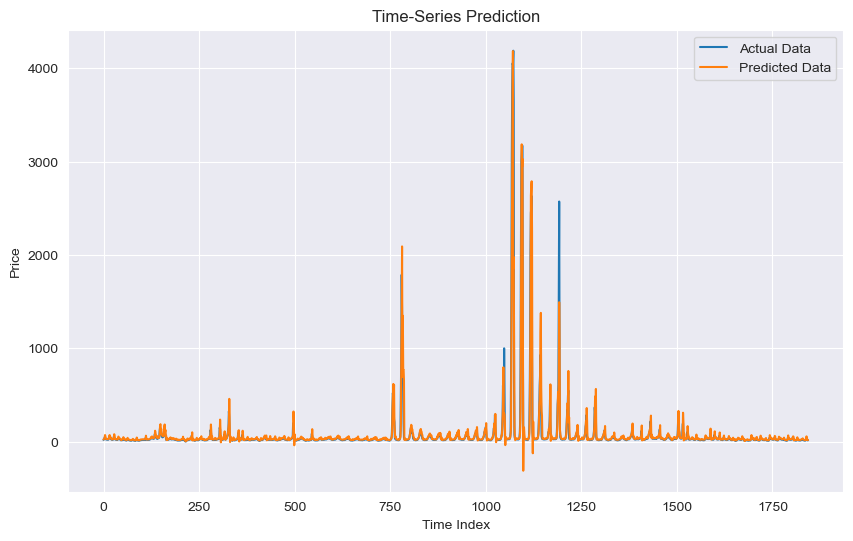

In [56]:
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
lstm_model.eval()

with torch.no_grad():
    # Generate predictions for the validation set
    val_predictions = lstm_model(X_val_tensor.cuda())
    # Inverse transform the predictions and actual data to original scale
    data_predict = scaler.inverse_transform(val_predictions.cpu().numpy())
    dataY_plot = scaler.inverse_transform(y_val_tensor.cpu().numpy())
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(dataY_plot, label='Actual Data')
    plt.plot(data_predict, label='Predicted Data')
    plt.title('Time-Series Prediction')
    plt.xlabel('Time Index')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [58]:
# save the model's state dictionary
torch.save(lstm_model.state_dict(), 'lstm_model_price_non-weather.pth')
# RMS Error
mse = np.mean(np.square(dataY_plot - data_predict))
# Calculate the root mean squared error
rmse = np.sqrt(mse)
print("Root Mean Squared Error: %1.5f" % rmse)

Root Mean Squared Error: 112.17717


In [59]:
import pandas as pd

# Assuming data_predict and dataY_plot are numpy arrays containing your predictions and actual values respectively
# First, create a pandas DataFrame
df_predictions = pd.DataFrame({
    'Actual Price': dataY_plot.flatten(),  # Flatten in case the data is in a multi-dimensional array
    'Predicted Price': data_predict.flatten()
})

# Now, you can save this DataFrame to a CSV file
csv_file_path = 'price_predictions.csv'  # Specify your desired file path and name
df_predictions.to_csv(csv_file_path, index=False)  # Save the DataFrame without the index

print(f"Predictions saved to {csv_file_path}")

Predictions saved to price_predictions.csv


In [ ]:
# Normalize the price data for account A
scaler_a = MinMaxScaler(feature_range=(-1, 1))
scaled_prices_a = scaler_a.fit_transform(account_a_data.values.reshape(-1, 1))

# Convert the data to sequences for account A
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 4  # Number of time steps to look back
X_a, y_a = create_sequences(scaled_prices_a, seq_length)

# Split the data into training and test sets for account A
train_size_a = int(len(y_a) * 0.67)
test_size_a = len(y_a) - train_size_a

X_train_a, y_train_a = X_a[:train_size_a], y_a[:train_size_a]
X_test_a, y_test_a = X_a[train_size_a:], y_a[train_size_a:]

# Convert to PyTorch tensors for account A
X_train_tensor_a = torch.tensor(X_train_a, dtype=torch.float32)
y_train_tensor_a = torch.tensor(y_train_a, dtype=torch.float32)
X_test_tensor_a = torch.tensor(X_test_a, dtype=torch.float32)
y_test_tensor_a = torch.tensor(y_test_a, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for account A
train_dataset_a = TensorDataset(X_train_tensor_a, y_train_tensor_a)
train_loader_a = DataLoader(train_dataset_a, batch_size=64, shuffle=True)

test_dataset_a = TensorDataset(X_test_tensor_a, y_test_tensor_a)
test_loader_a = DataLoader(test_dataset_a, batch_size=64, shuffle=False)

# Normalize the price data for account B
scaler_b = MinMaxScaler(feature_range=(-1, 1))
scaled_prices_b = scaler_b.fit_transform(account_b_data.values.reshape(-1, 1))

# Convert the data to sequences for account B
X_b, y_b = create_sequences(scaled_prices_b, seq_length)

# Split the data into training and test sets for account B
train_size_b = int(len(y_b) * 0.67)
test_size_b = len(y_b) - train_size_b

X_train_b, y_train_b = X_b[:train_size_b], y_b[:train_size_b]
X_test_b, y_test_b = X_b[train_size_b:], y_b[train_size_b:]

# Convert to PyTorch tensors for account B
X_train_tensor_b = torch.tensor(X_train_b, dtype=torch.float32)
y_train_tensor_b = torch.tensor(y_train_b, dtype=torch.float32)
X_test_tensor_b = torch.tensor(X_test_b, dtype=torch.float32)
y_test_tensor_b = torch.tensor(y_test_b, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for account B
train_dataset_b = TensorDataset(X_train_tensor_b, y_train_tensor_b)
train_loader_b = DataLoader(train_dataset_b, batch_size=64, shuffle=True)

test_dataset_b = TensorDataset(X_test_tensor_b, y_test_tensor_b)
test_loader_b = DataLoader(test_dataset_b, batch_size=64, shuffle=False)


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [118]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Assuming LSTM class is already defined as provided before
# Assuming create_sequences, MinMaxScaler, DataLoader, and TensorDataset are already imported

# Model parameters for Account A
input_size_a = 1  # As we have one feature, the scaled price
hidden_size_a = 50  # Number of features in the hidden state
num_layers_a = 1  # One-layer LSTM
output_size_a = 1  # As we want to predict one value at a time

# Instantiate the model for Account A
lstm_a = LSTM(input_size_a, hidden_size_a, num_layers_a, output_size_a)
lstm_a = lstm_a.cuda()  # Move model to GPU

# Loss and optimizer for Account A
criterion_a = nn.MSELoss()
optimizer_a = torch.optim.Adam(lstm_a.parameters(), lr=0.001)

# Train the model for Account A
num_epochs_a = 1000  # You can adjust the number of epochs
lstm_a.train()  # Set model to training mode

for epoch in range(num_epochs_a):
    total_loss_a = 0
    for sequences_a, prices_a in train_loader_a:
        sequences_a, prices_a = sequences_a.cuda(), prices_a.cuda()
        optimizer_a.zero_grad()  # Clear gradients
        outputs_a = lstm_a(sequences_a)  # Forward pass
        loss_a = criterion_a(outputs_a, prices_a)  # Compute loss
        loss_a.backward()  # Backward pass
        optimizer_a.step()  # Update weights
        total_loss_a += loss_a.item()

    # Print average loss every 100 epochs for Account A
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs_a}], Loss: {total_loss_a/len(train_loader_a):.4f}')

# Save the model after training for Account A
torch.save(lstm_a.state_dict(), 'lstm_model_price_account_a.pth')

# Evaluation for Account A
lstm_a.eval()  # Set the model to evaluation mode
test_losses_a = []
with torch.no_grad():
    for sequences_a, prices_a in test_loader_a:
        sequences_a, prices_a = sequences_a.cuda(), prices_a.cuda()
        outputs_a = lstm_a(sequences_a)
        loss_a = criterion_a(outputs_a, prices_a)
        test_losses_a.append(loss_a.item())

average_test_loss_a = sum(test_losses_a) / len(test_losses_a)
print(f'Average Test Loss for Account A: {average_test_loss_a:.4f}')


Epoch [0/1000], Loss: 0.1499
Epoch [100/1000], Loss: 0.0023
Epoch [200/1000], Loss: 0.0014
Epoch [300/1000], Loss: 0.0013
Epoch [400/1000], Loss: 0.0013
Epoch [500/1000], Loss: 0.0010
Epoch [600/1000], Loss: 0.0008
Epoch [700/1000], Loss: 0.0007
Epoch [800/1000], Loss: 0.0006
Epoch [900/1000], Loss: 0.0006
Average Test Loss for Account A: 0.0013


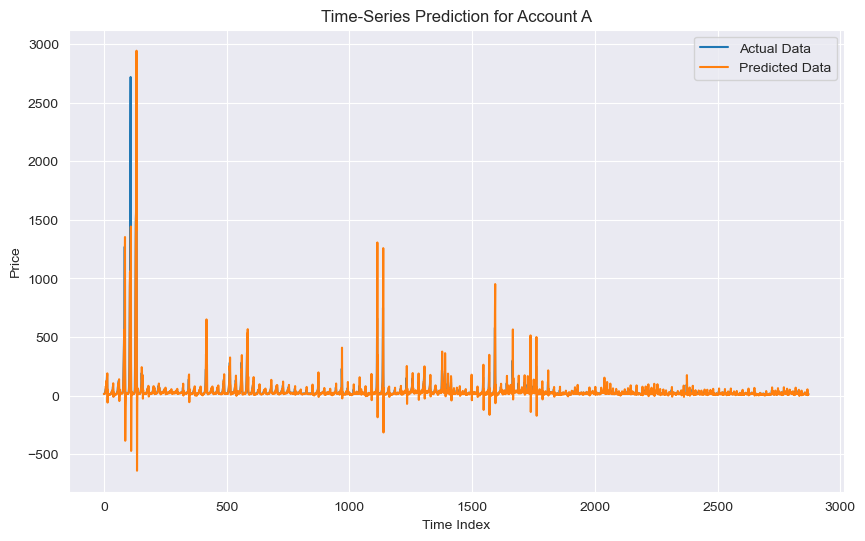

Root Mean Squared Error: 76.82786


In [120]:
# Plot the predictions for Account A
lstm_a.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Generate predictions for the test set
    test_predict_a = lstm_a(X_test_tensor_a.cuda())
    # Inverse transform the predictions and actual data
    data_predict_a = scaler_a.inverse_transform(test_predict_a.cpu().numpy())
    dataY_plot_a = scaler_a.inverse_transform(y_test_tensor_a.cpu().numpy())
    
    # Plotting
    plt.figure(figsize=(10,6))
    plt.plot(dataY_plot_a, label='Actual Data')
    plt.plot(data_predict_a, label='Predicted Data')
    plt.title('Time-Series Prediction for Account A')
    plt.xlabel('Time Index')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
# RMS Error
mse = np.mean(np.square(dataY_plot_a - data_predict_a))
# Calculate the root mean squared error
rmse = np.sqrt(mse)
print("Root Mean Squared Error: %1.5f" % rmse)